In [1]:
#libs for reading data
import xarray as xr
import intake
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import cartopy.crs as ccrs

#lib for dask gateway
from dask_gateway import Gateway
from dask.distributed import Client
from dask import delayed

In [2]:
gateway = Gateway()
cluster = gateway.new_cluster()
cluster.adapt(minimum=1, maximum=75)
client = Client(cluster)
cluster

In [3]:
%%time
cat_pangeo = intake.open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/master.yaml")

ds_ccmp = cat_pangeo.atmosphere.nasa_ccmp_wind_vectors.to_dask()

#calculate wind speed and add attributes to new variable
ds_ccmp['wspd'] = np.sqrt(ds_ccmp.uwnd**2 + ds_ccmp.vwnd**2)
ds_ccmp.wspd.attrs=ds_ccmp.uwnd.attrs
ds_ccmp.wspd.attrs['long_name']='wind speed at 10 meters'

ds_ccmp

CPU times: user 342 ms, sys: 58.3 ms, total: 400 ms
Wall time: 1.22 s


,Array,Chunk
Bytes,175.05 GB,226.08 MB
Shape,"(48392, 628, 1440)","(2000, 157, 180)"
Count,801 Tasks,800 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,175.05 GB,226.08 MB
Shape,"(48392, 628, 1440)","(2000, 157, 180)"
Count,801 Tasks,800 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [5]:
ccmp_buoy = ds_ccmp.interp(latitude=20,longitude=-160,method='nearest')
ts_ccmp_climatology = ccmp_buoy.groupby('time.dayofyear').mean('time',keep_attrs=True,skipna=True)
ts_ccmp_anomaly = (ccmp_buoy.groupby('time.dayofyear')-ts_ccmp_climatology)

/srv/conda/envs/notebook/lib/python3.8/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


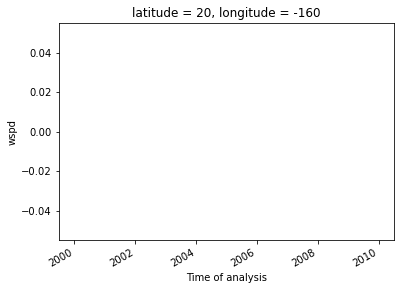

In [6]:
ts_ccmp_anomaly.wspd.plot()

# Compare to buoy data
Data from NDBC buoys, which measure wind speed are [here](https://dods.ndbc.noaa.gov/) and can be read via an THREDDS server.
- read in NDBC buoy data
- find closest CCMP data and linearly interpolate to buoy location
- examine a timeseries, caluclate bias and STD

In [ ]:
url='https://dods.ndbc.noaa.gov/thredds/dodsC/data/cwind/51003/51003.ncml'

with xr.open_dataset(url) as ds:
    # The longitude is on a -180 to 180, CCMP is 0-360, so make sure to convert
    ds.coords['longitude'] = np.mod(ds['longitude'], 360)
    
#added this line to try and remove dask error, it doesn't help, but at least it runs now    
#ds = ds.sortby(ds.time,ascending=True)
ds

In [ ]:
time_start = np.max([ds.time[0].data,ds_ccmp.time[0].data])
time_stop = np.min([ds.time[-1].data,ds_ccmp.time[-1].data])

#cut off time before / after ccmp obs, linearly interpol data for buoy location
ccmp_buoy = ds_ccmp.sel(time=slice(time_start,time_stop)).interp(latitude=ds.latitude,longitude=ds.longitude,method='linear')

#cut off time before / after ccmp obs
ds = ds.sel(time=slice(time_start,time_stop))

In [ ]:
%%time

# go from 30 min to 6-hourly sampling, resample with mean for +- 3 hours centered on timestamp
#ds = ds.resample(time='6H',loffset='180min',base=3).mean()  
# OMG!!! resample is sooo slow.  doing this cludge instead, same to within 6 significant digits

ds = ds.rolling(time=36,center=True).mean() 
ds_buoy = ds.interp(time=ccmp_buoy.time,method='nearest')

ds_buoy

In [ ]:
# I added this to try and remove the dask error, it is still there but it at least runs now. 
#ds_buoy = ds_buoy.isel(latitude=0,longitude=0)
#ccmp_buoy = ccmp_buoy.isel(latitude=0,longitude=0)

#THIS is the fix --- I have to run .computer() here for this to not error out. If you comment .compute() the next cell down will show the error
ccmp_buoy = ccmp_buoy.chunk({"time": 24797}).compute()

In [ ]:
%%time
# let's remove the seasonal cycle so we can compare the data more clearly
#for ccmp data create the climatology and anomaly
ts_ccmp_climatology = ccmp_buoy.groupby('time.dayofyear').mean('time',keep_attrs=True,skipna=True)
ts_ccmp_anomaly = (ccmp_buoy.groupby('time.dayofyear')-ts_ccmp_climatology).compute()

In [ ]:
%%time
# let's remove the seasonal cycle so we can compare the data more clearly
#for buoy data create the climatology and anomaly
ts_buoy_climatology = ds_buoy.groupby('time.dayofyear').mean('time',keep_attrs=True,skipna=True)
ts_buoy_anomaly = (ds_buoy.groupby('time.dayofyear')-ts_buoy_climatology).compute()

In [ ]:
(ts_ccmp_anomaly.wspd-ts_buoy_anomaly.wind_spd).plot()

In [ ]:
print('buoy minus satellite wind speeds')
rdif = (ts_buoy_anomaly.wind_spd-ts_ccmp_anomaly.wspd)
print('mean:',rdif.mean().data)
print('std:',rdif.std().data)

In [ ]:
#cluster.close()

In [ ]:
client.close()